# MSDM5002 Assignment 5 

In [284]:
import pandas as pd
import numpy as np
import requests as req
from io import StringIO
from matplotlib import pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates

datefmt = mdates.DateFormatter('%d/%m')
style.use("seaborn")

## 1. COVID in Hong Kong

### a. Plot the number of (confirmed) cases and its 7-day moving average

In [208]:
def download_save(url,save_at="data"):
    r = req.get(url)
    df = pd.read_csv(StringIO(r.text))
    name = url.split("/")[-1]
    df.to_csv(f"{save_at}/{name}")
    return df

In [209]:
df = download_save("http://www.chp.gov.hk/files/misc/latest_situation_of_reported_cases_covid_19_eng.csv")

In [193]:
dfa = pd.DataFrame({
    "Date":pd.to_datetime(df["As of date"],dayfirst=True),
    "Confirmed":df["Number of confirmed cases"],
    "NucleicAcid":df["Number of cases tested positive for SARS-CoV-2 virus by nucleic acid tests"],
    "RapidAntigen":df["Number of cases tested positive for SARS-CoV-2 virus by rapid antigen tests"]
})

dfa.NucleicAcid.fillna(0,inplace=True)
dfa.RapidAntigen.fillna(0,inplace=True)
dfa.Confirmed.fillna(dfa.NucleicAcid + dfa.RapidAntigen,inplace=True)
dfa["Daily"]=dfa.Confirmed.diff()
dfa["SMA7"] = dfa.Daily.rolling(7,center=True).mean()
dfa.drop(index=dfa.index[dfa.Date=="2020-02-29"],inplace=True)

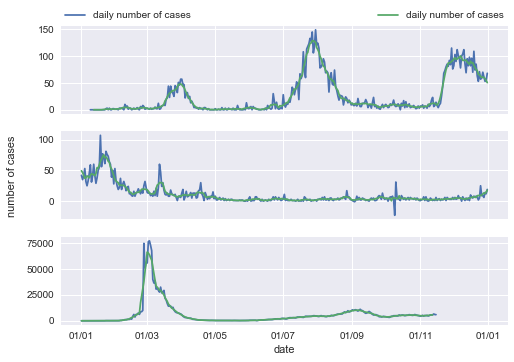

In [207]:
fig,axes = plt.subplots(3,1,sharex=True)
for i,ax in enumerate(axes):
    df_annual = dfa[dfa.Date.dt.year==(2020+i)]
    date = df_annual.Date.apply(lambda x: x.replace(year=1970))
    ax.xaxis.set_major_formatter(datefmt)
    ax.plot(date, df_annual.Daily,label="daily number of cases")
    ax.plot(date, df_annual.SMA7,label="daily number of cases")
    if i == 0:
        ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)

fig.text(0.04, 0.5, 'number of cases', va='center', ha='center', rotation='vertical', fontsize=plt.rcParams['axes.labelsize'])
plt.xlabel("date")
plt.show()

### b. Boil them down into two large categories, viz. “local case” and “imported case”: 
a case is local if the name of its original type has the word “local(ly)”, otherwise it is imported. Plot 
the number of these two types of cases with a stacked chart

In [277]:
df = download_save("http://www.chp.gov.hk/files/misc/enhanced_sur_covid_19_eng.csv")

In [222]:
dfb = pd.DataFrame({
    "Date":pd.to_datetime(pd.to_datetime(df["Report date"],dayfirst=True)),
    "Classification":df["Classification*"]
})
Iidx = dfb.Classification.isin(["Imported case","Epidemiologically linked with imported case"])
dfbI = dfb[Iidx]
dfbL = dfb[~Iidx]

In [255]:
dfbIStats = pd.Series(0,index=dfb.Date.unique())
dfbIStats.update(dfbI.value_counts(subset="Date",sort=False))
dfbLStats = pd.Series(0,index=dfb.Date.unique())
dfbLStats.update(dfbL.value_counts(subset="Date",sort=False))

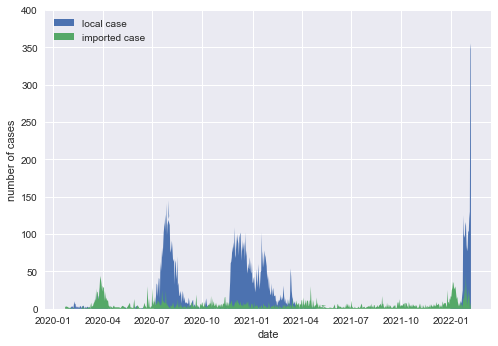

In [261]:
plt.fill_between(dfbLStats.index,dfbLStats.values,label="local case")
plt.fill_between(dfbIStats.index,dfbIStats.values,label="imported case")
plt.xlabel("date")
plt.ylabel("number of cases")
plt.ylim([0,400])
plt.legend(loc="upper left")
plt.show()

### c. Using the same CSV file as (b), now consider three columns “Report date”, “Gender”, and “Age”. Plot the age and gender distribution of the cases with a bar chart. 
The patients’ ages are binned into tens. 

In [278]:
df.Age.replace("<1",0, inplace=True)
df.Age.replace("Pending",-1, inplace=True)
MAges = df[df.Gender == "M"].Age.values.astype(int)
FAges = df[df.Gender == "F"].Age.values.astype(int)

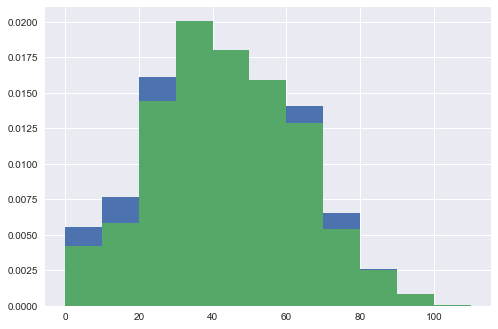

In [289]:
bins=np.linspace(0,110,12)
plt.subplots
plt.hist(MAges[MAges>=0],bins,density=True)
plt.hist(FAges[FAges>=0],bins,density=True)
plt.show()